<a href="https://colab.research.google.com/github/puneetsingla17/Reinforcement-Learning-Pytorch/blob/master/DQN_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y

# Special gym environment
!pip install gym[atari]

# For rendering environment, you can use pyvirtualdisplay.
!pip install pyvirtualdisplay
!pip install piglet

# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

# Import libraries
#
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [6]:
# Install spinningup on CoLab
!git clone https://github.com/openai/spinningup.git
!cd spinningup
#!pip install -e . # this will incur error: File "setup.py" not found. Directory cannot be installed in editable mode: /content
!pip install -e spinningup

fatal: destination path 'spinningup' already exists and is not an empty directory.
Obtaining file:///content/spinningup
  Found existing installation: spinup 0.2.0
    Can't uninstall 'spinup'. No files were found to uninstall.
  Running setup.py develop for spinup


In [67]:
# Utility functions to enable video recording of gym environment and displaying it
# To enable video, just do "env = wrap_env(env)""
# """

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [58]:
# env_fn = lambda : gym.make('LunarLander-v2')

In [59]:
import gym

In [21]:
env1=gym.make("LunarLander-v2")

In [22]:
env1.reset()

array([ 0.00584812,  1.4081824 ,  0.5923288 , -0.12169501, -0.00676966,
       -0.13417134,  0.        ,  0.        ], dtype=float32)

In [23]:
p=env1.step(3)

In [24]:
p

(array([ 0.01178217,  1.4048737 ,  0.602305  , -0.14711706, -0.01556032,
        -0.17582951,  0.        ,  0.        ], dtype=float32),
 -2.1130362041730266,
 False,
 {})

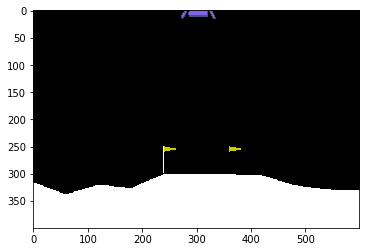

In [25]:
# get numpy array image if an environment
plt.imshow(env1.render("rgb_array"))

In [26]:
obsshape=env1.observation_space.shape
action=env1.action_space.n

In [29]:
#Hyperparameters
buffersize=100000
batchsize=64
gamma=0.99
tau=0.99
epsilon=0.9
steps=200000
warmupsteps=500
eps=1
epsend=0.01
epsdecay=0.999

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from collections import deque
import random
import torch.optim as op

In [31]:
class model(nn.Module):
  def __init__(self,inpdim,acdim):
    super().__init__()
    self.fc1=nn.Linear(inpdim,32)
    self.ln=nn.LayerNorm(32)
    self.fc2=nn.Linear(32,16)
    self.fc3=nn.Linear(16,acdim)
  def forward(self,x):
    out=f.leaky_relu(self.fc1(x))
    out=self.ln(out)
    out=f.leaky_relu(self.fc2(out))
    return self.fc3(out)

In [32]:
# remember output values of the model is a Qvalues for a state for every action
# we gonna follow espilon greedy policy
# we gonna do sarsamax

In [33]:
class replaybuffer:
  def __init__(self,maxlen):
    self.deque=deque(maxlen=maxlen)
  
  def add_data(self,s,a,r,d,snext):
    state=torch.FloatTensor(s)
    reward=torch.FloatTensor([r])
    nextstate=torch.FloatTensor(snext)
    self.deque.append([state,a,reward,d,nextstate])
  
  def sample(self,bs):
    batch=random.sample(self.deque,k=bs)
    state,action,reward,don,nextstate=zip(*batch)
    state=torch.stack(state,0)
    action=torch.LongTensor(action)
    done=torch.LongTensor(don)
    reward=torch.stack(reward,0)
    nextstate=torch.stack(nextstate,0)
    return state,action,reward,done,nextstate

In [34]:
class agent:
  def __init__(self,obsdim,naction,tau):
    self.targetagent=model(obsdim,naction)
    self.agent=model(obsdim,naction)
    self.tau=tau
    self.buffer=replaybuffer(buffersize)
    self.na=naction
    self.optim=op.Adam(self.agent.parameters(),lr=0.0001)

  def softupdate(self):
    for m,n in zip(self.targetagent.parameters(),self.agent.parameters()):
      m.data.copy_(self.tau*(m)+(1-self.tau)*n)
  
  def hardupdate(self):
    for m,n in zip(self.targetagent.parameters(),self.agent.parameters()):
      m.data.copy_(n)

  def act(self,s,epsilon):
    self.agent.eval()
    with torch.no_grad():
      actvals=self.agent(s)
    self.agent.train()
    #epsilon random policy

    if random.random()>epsilon:
      ac=actvals.argmax().item()
    else:
      ac=random.choice(range(self.na))
    return ac
  
  def train(self):
    self.optim.zero_grad()
    batch=self.buffer.sample(batchsize)
    qval=self.agent.forward(batch[0])
    qvalf=torch.gather(qval,1,batch[1].unsqueeze(1))
    qnextval=self.targetagent.forward(batch[-1]).data
    qmaxval=torch.max(qnextval,1)[0]
    qmaxval[batch[-2]]=0

    targetq=batch[2]+gamma*qmaxval.unsqueeze(-1)
    loss=f.mse_loss(qvalf,targetq)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.agent.parameters(),1)  #Clipping for stability
    self.optim.step()


In [35]:
ag=agent(obsshape[0],action,tau)

In [36]:
#Testing if code works
st=torch.rand(obsshape)

In [37]:
st1=env1.reset()

In [38]:
meanreward=deque(maxlen=100)

In [39]:
ag.hardupdate()

In [40]:
0.999**10000

4.517334597704824e-05

In [41]:
rewardlist=[]
eps1=eps
for i in range(steps):
  st=torch.tensor(st1)
  eps1=max(eps1*epsdecay,epsend)
  ac=ag.act(st,eps1)
  try:
    nextst,rew,done,_=env1.step(ac)
  except:
    print(ac)
    break
  
  ag.buffer.add_data(st1,ac,rew,done,nextst)
  meanreward.append(rew)
  
  if done:
    st1=env1.reset()
  else:
    st1=nextst
  
  if i<warmupsteps:
    continue

  if (i%4)==0:
    ag.softupdate()
  if (i%2)==0:
    ag.train()
    rewardlist.append(sum(meanreward)/50.0)

In [42]:
print(len(ag.buffer.deque))

100000


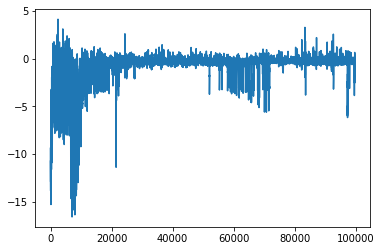

In [43]:
plt.plot(rewardlist)

In [44]:
rewardlist[-50:]

[0.6159157466504742,
 0.5419553898543054,
 0.5003439463615088,
 0.40800825798283336,
 0.3199417418712676,
 0.3453708988619828,
 0.241732337731674,
 0.29459502905086776,
 0.33510186679974835,
 0.22302560502546848,
 0.24381909438480442,
 0.28088614060407185,
 0.22768852436243386,
 0.2070925912601968,
 0.19415856403874612,
 0.19986669659670384,
 0.15574198624531652,
 0.17456977791833583,
 0.15869893773592214,
 0.14518633373953962,
 0.15817219735085258,
 0.12969097614337818,
 0.08853697142339119,
 0.1385498444294121,
 0.11255118188196293,
 0.06369933061488046,
 0.11280051105508675,
 0.04989091759933936,
 0.05416467168852032,
 0.060552859477894024,
 0.03780477334152235,
 -0.03174320660788227,
 -0.05691136463256072,
 -0.03163313174605973,
 -0.05208323241379105,
 -0.1477613039834813,
 -0.2126328872381837,
 -0.2106808831841389,
 -0.22733998856239496,
 -0.297933812824378,
 -0.2527836031791057,
 -0.2047382412143589,
 -0.1886181689069746,
 -0.20731334489515396,
 -0.2535246534902314,
 -0.180754198

In [98]:
env1 = wrap_env(gym.make("LunarLander-v2"))

In [99]:
s1=env1.reset()

In [100]:
s1=torch.FloatTensor(s1).view(1,-1)

In [101]:
ac

0

In [102]:
count=0
while count<500:
  env1.render("rgb_array")
  # obs=ptan.agent.float32_preprocessor(obs)
  # action=model.forward(obs)[0].data.cpu().numpy()
  #action=ag.act(s1,1)
  action=random.choice([0,1,2,3])
  print(action)
  obs,rew,done,_=env1.step(action)
  s1=torch.FloatTensor(obs).view(1,-1)
  count+=1
  if done:
    break

env1.close()

1
3
3
2
3
1
3
0
3
3
2
1
3
3
0
2
0
3
1
0
1
2
2
1
2
0
2
1
0
2
3
2
0
0
2
2
0
0
3
3
3
2
3
0
0
1
0
3
0
2
2
3
2
0
0
1
1
1
1
3


In [103]:
show_video()

In [94]:
rew

-100

In [95]:
env1.reward_range

(-inf, inf)